# ViT-based model using Transfer-Learning
---
#### Model: google/vit-base-patch16-224, descongelando las últimas 3 capas del encoder
#### Epochs: 10
#### Dataset: images_massas_balanced_A

In [1]:
# Parámetros
_model = 'google/vit-base-patch16-224'
_checkpoint = None  # path al checkpoint a cargar
_output = 'SavedModels/ViT-patch16-224_C'  # path para guardar el modelo

_dataset = '/Users/julio/Documentos-Local/data/VinDr-Mammo/subsets/images_massas_balanced_A'
_dataset_split_path = '/Users/julio/Documentos-Local/data/VinDr-Mammo/subsets/images_massas_balanced_A_split'  # path para guardar el dataset con split
_dataset_split = _dataset_split_path  # path al dataset ya separado en train, validation y test

_batch_size = 16
_learning_rate = 3e-4
_epochs = 30

num_layers_to_unfreeze = 3  # Definir el número de capas a descongelar, None eoc

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from datasets import load_dataset, DatasetDict, load_from_disk

from transformers import AutoImageProcessor, ViTForImageClassification

from transformers import Trainer, TrainingArguments

import evaluate

from Utils import *

## Carga de datos

In [3]:
if _dataset_split is None:
    dataset = load_dataset(_dataset)
else:
    # Cargar el dataset previamente guardado
    dataset = load_from_disk(_dataset_split_path)

dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 8000
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
})

### Revisión de categorías

In [4]:
labels = dataset['train'].features['label'].names
print(len(labels),labels)

label2id = {c:idx for idx,c in enumerate(labels)}
id2label = {idx:c for idx,c in enumerate(labels)}

2 ['calcificaciones', 'masas']


## Muestra de ejemplos

In [6]:
def show_samples(ds,rows,cols):
    samples = ds.shuffle().select(np.arange(rows*cols)) # selecting random images
    fig = plt.figure(figsize=(cols*4,rows*4))
    # plotting
    for i in range(rows*cols):
        img = samples[i]['image']
        label = samples[i]['label']
        fig.add_subplot(rows,cols,i+1)
        plt.imshow(img, cmap='gray')
        plt.title(label)
        plt.axis('off')
            
# show_samples(dataset['train'],rows=3,cols=5)

## Split Dataset

In [5]:
if _dataset_split is None:
    split_dataset = dataset['train'].train_test_split(test_size=0.2)
    eval_dataset = split_dataset['test'].train_test_split(test_size=0.5)
    
    
    # Recombinar los splits 
    
    final_dataset = DatasetDict({
        'train': split_dataset['train'],
        'validation': eval_dataset['train'],
        'test': eval_dataset['test']
    })
    # Guardar el dataset dividido
    final_dataset.save_to_disk(_dataset_split_path)

else:
    final_dataset = dataset
final_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 8000
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
})

## Preprocesamiento de las imágenes

In [10]:
processor = AutoImageProcessor.from_pretrained(_model, use_fast=True)
processor

ViTImageProcessorFast {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessorFast",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [11]:
def transforms(batch):
    batch['image'] = [x.convert('RGB') for x in batch['image']]
    inputs = processor(batch['image'],return_tensors='pt')
    inputs['labels'] = batch['label']  # Las clases ya están en formato numérico
    return inputs

In [12]:
processed_dataset = final_dataset.with_transform(transforms)

### Data Collation

In [13]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

## Métricas de evaluación

In [14]:
accuracy = evaluate.load('accuracy')
precision = evaluate.load('precision')
recall = evaluate.load('recall')
f1 = evaluate.load('f1')

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=1)

    accuracy_score = accuracy.compute(predictions=predictions, references=labels)
    precision_score = precision.compute(predictions=predictions, references=labels)
    recall_score = recall.compute(predictions=predictions, references=labels)
    f1_score = f1.compute(predictions=predictions, references=labels)

    return {
        'accuracy': accuracy_score['accuracy'],
        'precision': precision_score['precision'],
        'recall': recall_score['recall'],
        'f1': f1_score['f1']
    }

## Carga del modelo

In [15]:
model = ViTForImageClassification.from_pretrained(
    _model,
    num_labels = len(labels),
    id2label = id2label,
    label2id = label2id,
    ignore_mismatched_sizes = True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Arquitectura del modelo

In [16]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

### Congelar todas las capas, menos el clasificador

In [17]:
for name,p in model.named_parameters():
    if not name.startswith('classifier'):
        p.requires_grad = False

In [18]:
num_params = sum([p.numel() for p in model.parameters()])
trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])

print(f"{num_params = :,} | {trainable_params = :,}")

num_params = 85,800,194 | trainable_params = 1,538


### Descongelar capas del encoder para fine-tuning

In [19]:
# Obtener el número total de capas en el encoder
num_total_layers = len(list(model.vit.encoder.layer))  # Debería ser 24 para ViT-Large, 12 para ViT-base
print(num_total_layers)

12


In [20]:
# Si se descongelan capas
if num_layers_to_unfreeze is not None:
    # Calcular el índice a partir del cual descongelar
    unfreeze_from = num_total_layers - num_layers_to_unfreeze
    
    # Iterar sobre todas las capas del encoder
    for idx, layer in enumerate(model.vit.encoder.layer):
        if idx >= unfreeze_from:
            # Descongelar esta capa
            for param in layer.parameters():
                param.requires_grad = True
        else:
            # Congelar esta capa
            for param in layer.parameters():
                param.requires_grad = False


In [21]:
# Mostrar el número total de parámetros y los entrenables después de descongelar
num_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Después de descongelar las últimas {num_layers_to_unfreeze} capas:")
print(f"Total de parámetros: {num_params:,}")
print(f"Parámetros entrenables: {trainable_params:,}")

Después de descongelar las últimas 3 capas:
Total de parámetros: 85,800,194
Parámetros entrenables: 21,265,154


In [24]:
# Revisión de trainable por capa
for name, param in model.named_parameters():
    status = "Trainable" if param.requires_grad else "Frozen"
    #print(f"{name}: {status}")

## Training

In [30]:
training_args = TrainingArguments(
    output_dir=_output,
    per_device_train_batch_size=_batch_size,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    num_train_epochs=_epochs,  # Epochs a entrenar -> Revisar
    learning_rate=_learning_rate,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='tensorboard',
    load_best_model_at_end=True,
)

In [31]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"],
    tokenizer=processor
)

In [32]:
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")
    print("MPS enabled")

MPS enabled


In [33]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.482300,0.667083,0.682000,0.928889,0.409002,0.567935
2,0.312000,0.450139,0.796000,0.778584,0.839530,0.807910
3,0.206200,0.509776,0.793000,0.895833,0.673190,0.768715
4,0.129800,0.686554,0.767000,0.875676,0.634051,0.735528
5,0.094700,0.879406,0.742000,0.904153,0.553816,0.686893
6,0.062200,0.694593,0.813000,0.780277,0.882583,0.828283
7,0.034500,0.699663,0.807000,0.823171,0.792564,0.807577
8,0.014500,0.766379,0.828000,0.867679,0.782779,0.823045
9,0.009000,0.768261,0.837000,0.883260,0.784736,0.831088
10,0.006600,0.747750,0.828000,0.849485,0.806262,0.827309


TrainOutput(global_step=5000, training_loss=0.13141595314145088, metrics={'train_runtime': 1954.7382, 'train_samples_per_second': 40.926, 'train_steps_per_second': 2.558, 'total_flos': 6.19935916916736e+18, 'train_loss': 0.13141595314145088, 'epoch': 10.0})

In [34]:
trainer.save_model()

### Evaluación del modelo

In [35]:
trainer.evaluate(processed_dataset['test'])

{'eval_loss': 0.46431300044059753,
 'eval_accuracy': 0.777,
 'eval_precision': 0.7429577464788732,
 'eval_recall': 0.845691382765531,
 'eval_f1': 0.7910028116213683,
 'eval_runtime': 16.7533,
 'eval_samples_per_second': 59.69,
 'eval_steps_per_second': 7.461,
 'epoch': 10.0}

## Inferencia en conjunto de test

In [ ]:
samples = final_dataset['test']
processed_samples = samples.with_transform(transforms)
predictions = trainer.predict(processed_samples).predictions.argmax(axis=1) # labels predichas

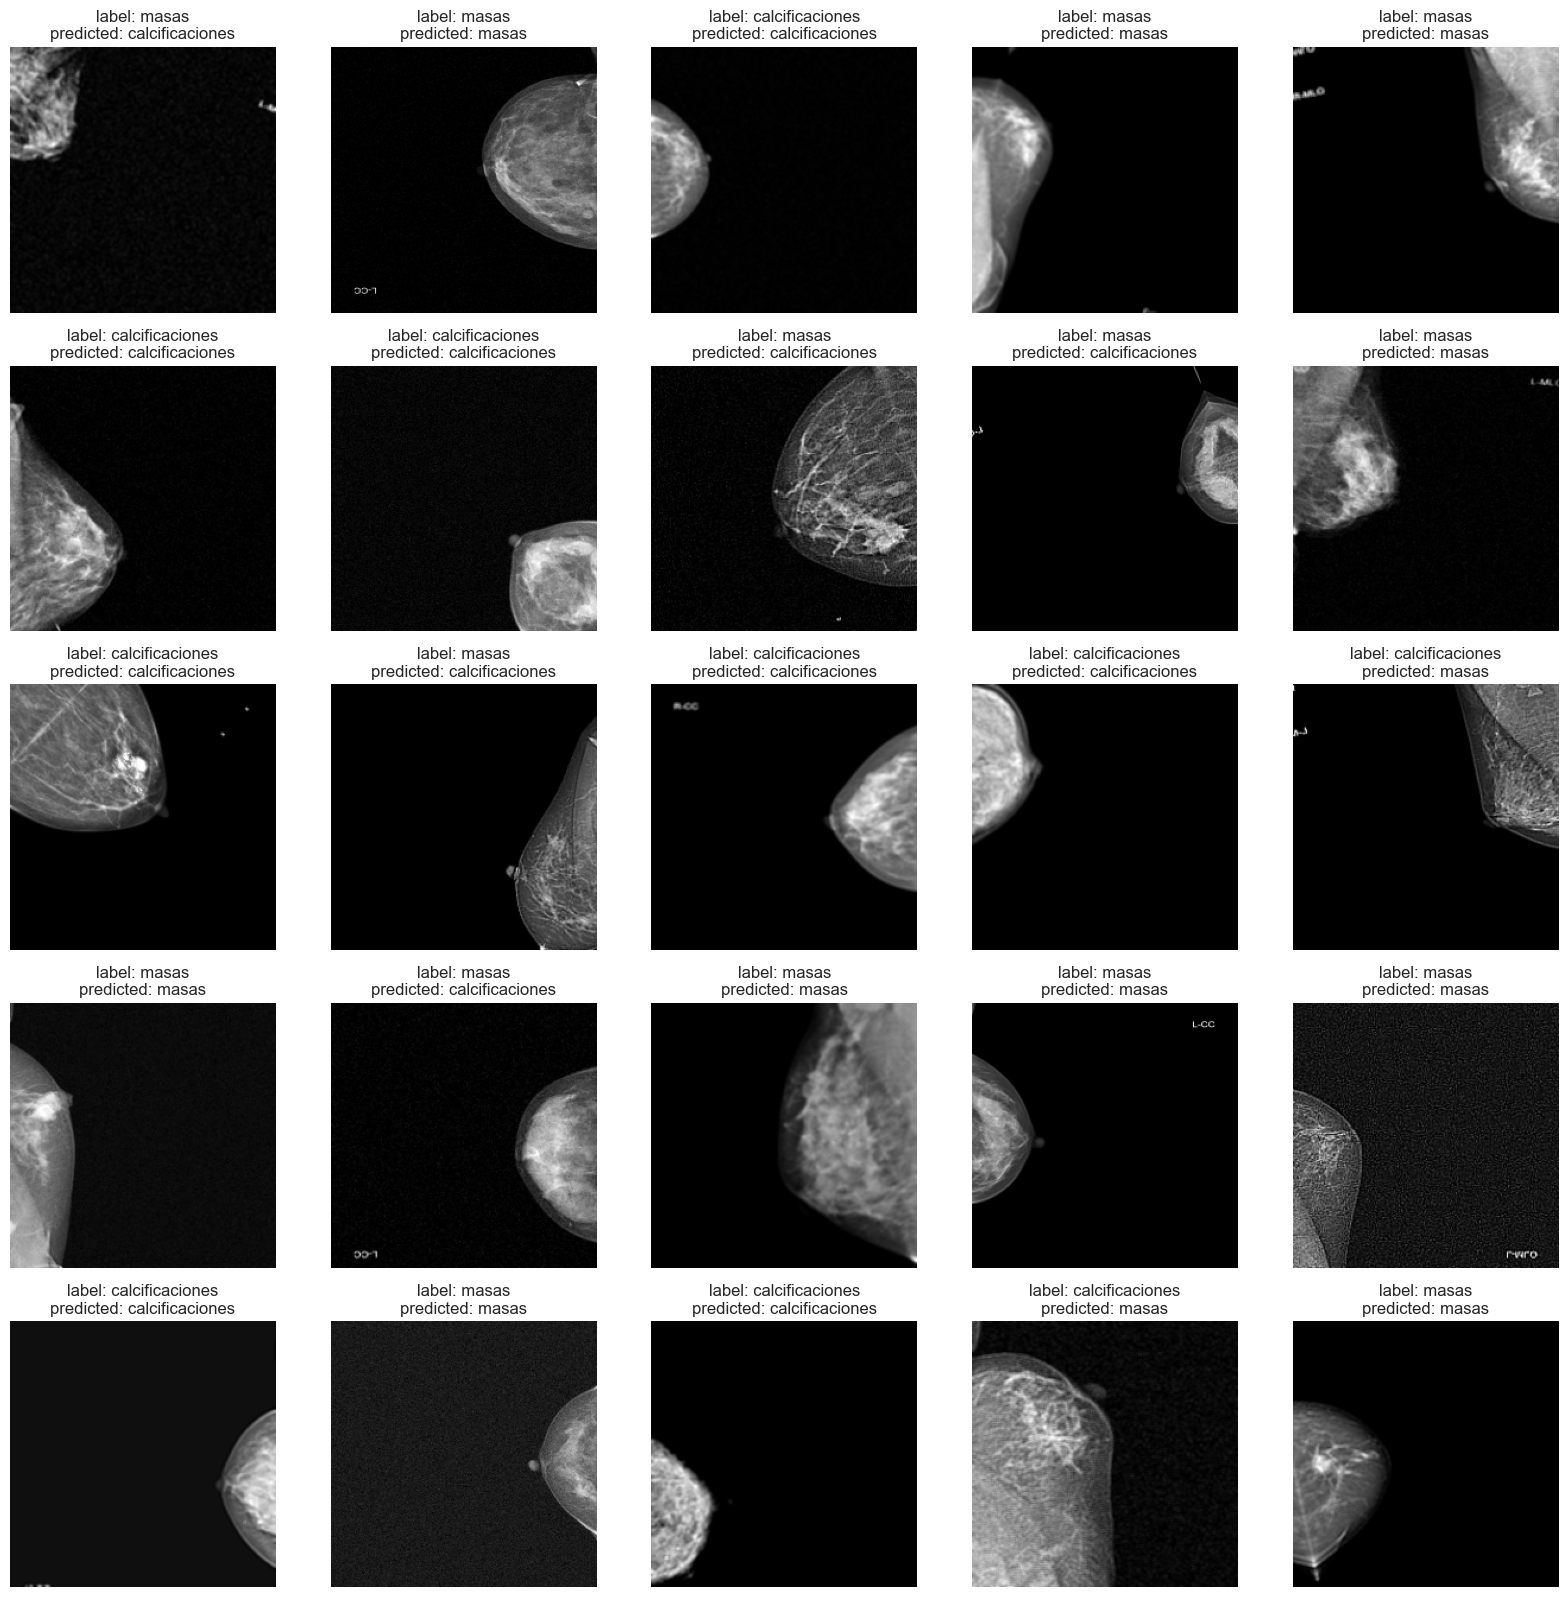

In [39]:
show_predictions(rows=5,cols=5, samples_=samples, predictions_=predictions, id2label_=id2label)

### Matriz de confusión

In [ ]:
confusion_matrix(samples_=samples, predictions_=predictions)

## Iterar por más epochs

In [40]:
trainer.train(resume_from_checkpoint=_checkpoint)
trainer.args.num_train_epochs = 30  # Para entrenar hasta la época 30

In [25]:
trainer.save_model()

In [41]:
trainer.evaluate(processed_dataset['test'])

In [42]:
show_predictions(rows=5,cols=5)